Przygotowanie środowiska

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(6, 6))

Zaczytanie danych, wybór kolumn przy ładowaniu

In [139]:
fields = ['P_ROKDYP',"P_N","P_POZIOM", # wartosci filtrujace
"P_E_ZAR_STUD_P5","P_E_ZAR_NSTUD_P5","P_E_ZAR_P5", #dane o zarobkach absolwentow po 5 latach
"P_E_ZAR_DOSW_P5","P_E_ZAR_NDOSW_P5",
"P_ME_ZAR_P5","P_ME_ZAR_DOSW_P5","P_ME_ZAR_NDOSW_P5",
"P_ME_ZAR_STUD_P5","P_ME_ZAR_NSTUD_P5",
"P_E_ZAR_ETAT_P5","P_E_ZAR_ETAT_DOSW_P5","P_E_ZAR_ETAT_NDOSW_P5",
"P_E_ZAR_ETAT_STUD_P5","P_E_ZAR_ETAT_NSTUD_P5",
"P_ME_ZAR_ETAT_P5","P_ME_ZAR_ETAT_DOSW_P5","P_ME_ZAR_ETAT_NDOSW_P5",
"P_ME_ZAR_ETAT_STUD_P5","P_ME_ZAR_ETAT_NSTUD_P5",
'P_NAZWA_UCZELNI',"P_NAZWA_KIERUNKU_PELNA","P_KIERUNEK_ID","P_FORMA","P_DZIEDZINA","P_WOJ"] #dane o uczelni i kierunku
data1 = pd.read_csv('dane/graduates-major-data.csv',sep=";",usecols=fields,decimal=',')

Redukcja pamieci

In [140]:
# drobna redukcja pamieci na kolumnach o pewnych wartosciach
data1["P_ROKDYP"] = data1["P_ROKDYP"].astype('int16')
data1["P_KIERUNEK_ID"] = data1["P_KIERUNEK_ID"].astype('int32')
data1["P_N"] = data1["P_N"].astype('int16')
data1["P_POZIOM"] =data1["P_POZIOM"].astype("category")
# problem z zamiana P_FORMA, przy grupowaniu powoduje memmory leak
# data1["P_FORMA"] =data1["P_POZIOM"].astype("category")
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41792 entries, 0 to 41791
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   P_ROKDYP                41792 non-null  int16   
 1   P_KIERUNEK_ID           41792 non-null  int32   
 2   P_POZIOM                41792 non-null  category
 3   P_FORMA                 41792 non-null  object  
 4   P_N                     41792 non-null  int16   
 5   P_E_ZAR_STUD_P5         2736 non-null   float64 
 6   P_E_ZAR_NSTUD_P5        7194 non-null   float64 
 7   P_E_ZAR_P5              14190 non-null  float64 
 8   P_E_ZAR_DOSW_P5         9247 non-null   float64 
 9   P_E_ZAR_NDOSW_P5        10511 non-null  float64 
 10  P_ME_ZAR_STUD_P5        2736 non-null   float64 
 11  P_ME_ZAR_NSTUD_P5       7194 non-null   float64 
 12  P_ME_ZAR_P5             14190 non-null  float64 
 13  P_ME_ZAR_DOSW_P5        9247 non-null   float64 
 14  P_ME_ZAR_NDOSW_P5     

Filtrowanie studentow po studiach magisterskich z 2014 i 2015 roku

In [141]:
# dane o absolwentach z roku 2014 i 2015 roku 
data1 = data1[(data1['P_ROKDYP']==2014) | (data1['P_ROKDYP']==2015)]
# studia magisterskie lub jednolitemagisterskie
data1 = data1[(data1['P_POZIOM']=="JM") | (data1['P_POZIOM']=="2")]

Sprawdzenie pustych wartosci

In [142]:
# duzo pustych wartosci jesli chodzi o informacje 
# -P_E_ZAR_P5, P_ME_ZAR_P5, ukazują najmniej brakujacych informacji
nullvalues = data1.isna().sum()
nullvalues[nullvalues > 0]

P_E_ZAR_STUD_P5           5013
P_E_ZAR_NSTUD_P5          3032
P_E_ZAR_P5                  16
P_E_ZAR_DOSW_P5           1541
P_E_ZAR_NDOSW_P5          1313
P_ME_ZAR_STUD_P5          5013
P_ME_ZAR_NSTUD_P5         3032
P_ME_ZAR_P5                 16
P_ME_ZAR_DOSW_P5          1541
P_ME_ZAR_NDOSW_P5         1313
P_E_ZAR_ETAT_STUD_P5      5097
P_E_ZAR_ETAT_NSTUD_P5     3037
P_E_ZAR_ETAT_P5             22
P_E_ZAR_ETAT_DOSW_P5      1677
P_E_ZAR_ETAT_NDOSW_P5     1492
P_ME_ZAR_ETAT_STUD_P5     5097
P_ME_ZAR_ETAT_NSTUD_P5    3037
P_ME_ZAR_ETAT_P5            22
P_ME_ZAR_ETAT_DOSW_P5     1677
P_ME_ZAR_ETAT_NDOSW_P5    1492
P_DZIEDZINA                 21
dtype: int64

Zgrupowanie danych o kierunkach z 2014 i 2015, dodanie wojewodztw tekstowych do badan

In [143]:
# zgrupowanie po kierunku na uczelni z podzialem na stacjonarne i niestacjonarne,
# liczba osob na kierunku zsumowana z lat 2014 i 2015, średnia płaca roczników uśredniona
# "P_DZIEDZINA","P_WOJ"
data1 = data1.groupby(["P_NAZWA_UCZELNI","P_KIERUNEK_ID","P_NAZWA_KIERUNKU_PELNA","P_FORMA","P_DZIEDZINA","P_WOJ"]).agg({
    "P_N" :'sum',"P_E_ZAR_P5":'mean',"P_ME_ZAR_P5":'mean',
})

In [144]:
# wybranie kierunkow posiadajacych conajmniej 30 absolwentow
data1 = data1[(data1['P_N']>=30)].reset_index()
# przypisanie wartosciom numerycznym wojewodztw wartosci tekstowe
wojewodztwa = {
    14:"Mazowieckie", 12:"Małopolskie", 24:"Śląskie",30:"Wielkopolskie",
    2:"Dolnoślaśkie",22:"Pomorskie",6:"Lubelskie",10:"Łódzkie",
    4:"Kujawsko-Pomorskie",32:"Zachodniopomorskie",18:"Podkarpackie",
    20:"Podlaskie",28:"Warmińsko-mazurskie",16:"Opolskie",
    26:"Świętokrzyskie", 8:"Lubuskie"
}
data1['P_WOJ']=data1['P_WOJ'].map(wojewodztwa)

In [145]:
# DOPISEK DO PREZENTACJI, ILE MAMY DANYCH O STUDENTACH Z 2014, 2015 ORAZ W SUMIE

Udział absolwentow stac i niestac w danych

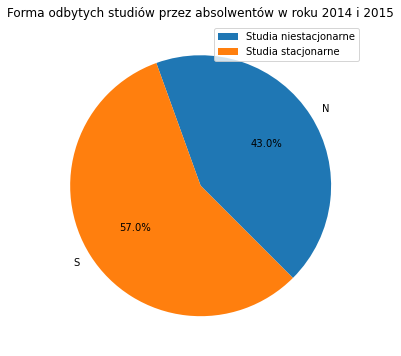

In [146]:
# Suma liczby absolwentow na studiach stacjonarnych i niestacjonarnych
formadata = data1.groupby(['P_FORMA']).agg({"P_N":"sum"})
formadata=formadata.reset_index()

plt.pie(formadata['P_N'],labels=formadata['P_FORMA'],autopct='%1.1f%%',startangle=-45)
plt.legend(['Studia niestacjonarne',"Studia stacjonarne"],loc="best")
plt.title("Forma odbytych studiów przez absolwentów w roku 2014 i 2015")
plt.savefig('plots/Udzial1.png', dpi=400, bbox_inches='tight')
plt.show()

Udzial kierunkow w dziedzinach

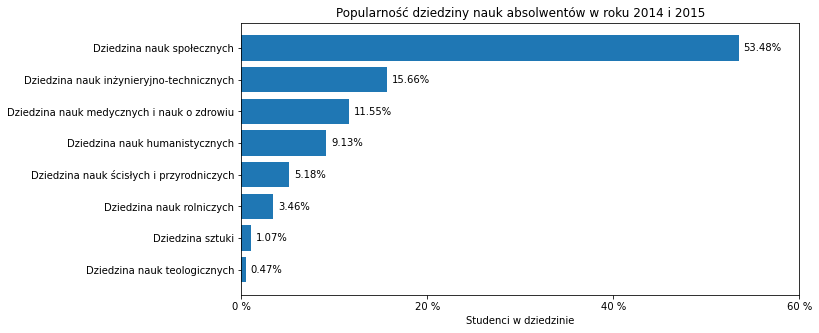

In [147]:
# zgrupowanie wedlug dziedziny i zliczenie kierunkow w tej dziedzinie
dziedzinadata = data1.groupby(["P_DZIEDZINA"])['P_N'].sum().sort_values(ascending=True)
dziedzinadata = dziedzinadata.reset_index()
dziedzinadata["P_N"] = dziedzinadata["P_N"] / dziedzinadata["P_N"].sum()

plt.figure(figsize=(10,5))
bars = plt.barh(y=dziedzinadata['P_DZIEDZINA'],width=dziedzinadata["P_N"])
plt.title("Popularność dziedziny nauk absolwentów w roku 2014 i 2015")
plt.bar_label(bars,labels=[f'{x:.2%}' for x in bars.datavalues],padding=5)
plt.xlabel("Studenci w dziedzinie")
plt.xticks([0,.2,.4,.6,.8,1],labels=["0 %","20 %","40 %","60 %","80 %","100 %"])
plt.xlim(right=.6)
plt.grid(False)
plt.savefig('plots/PopularnoscDziedzina.png', dpi=400, bbox_inches='tight')
plt.show()

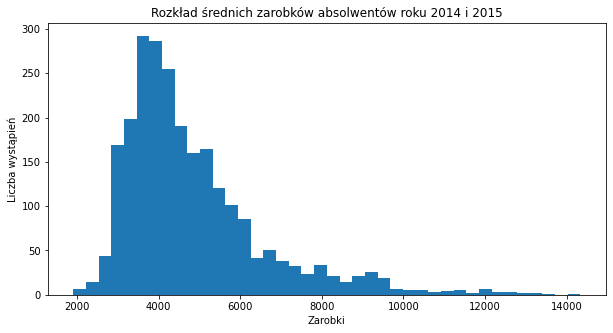

In [148]:
def wageDisrtributionPlot(target,plotTitle,savename):
    plt.figure(figsize=(10,5))
    plt.hist(x=target,bins=40)
    plt.title(plotTitle)
    plt.xlabel("Zarobki")
    plt.ylabel("Liczba wystąpień")
    plt.grid(False)
    plt.savefig(f'plots/{savename}.png', dpi=400, bbox_inches='tight')
    plt.show()

wageDisrtributionPlot(data1['P_E_ZAR_P5'],"Rozkład średnich zarobków absolwentów roku 2014 i 2015","RozkładZarobkowSr")

In [149]:
# % absolwentow zarabiających ponizej 6K
data1[data1['P_E_ZAR_P5']<5500]['P_E_ZAR_P5'].count() / data1['P_E_ZAR_P5'].count()*100

75.31516876779179

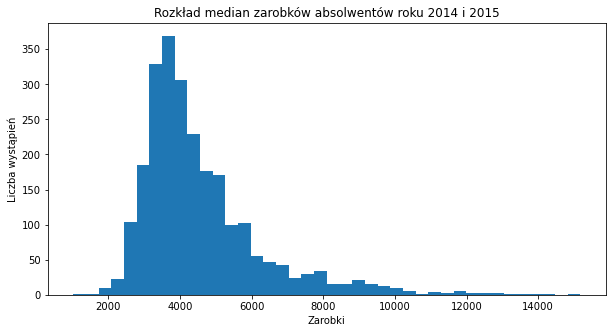

In [150]:
wageDisrtributionPlot(data1['P_ME_ZAR_P5'],"Rozkład median zarobków absolwentów roku 2014 i 2015","RozkładZarobkowMed")

In [151]:
# % absolwentow zarabiających ponizej 6K
data1[data1['P_ME_ZAR_P5']<5500]['P_ME_ZAR_P5'].count() / data1['P_ME_ZAR_P5'].count()*100

80.39853599023994

Średnie zarobki w dziedzinach

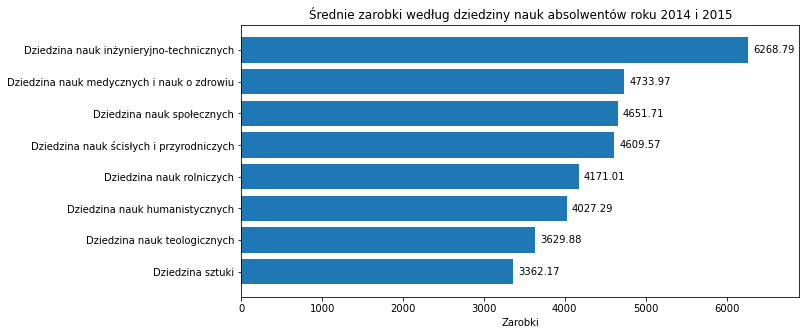

In [152]:
#srednie zarobki w dziedzinach nauk
zardziedatasr = data1.groupby("P_DZIEDZINA").agg({"P_E_ZAR_P5":'mean'}).sort_values(by="P_E_ZAR_P5",ascending=True)
zardziedatasr = zardziedatasr.reset_index()

def fieldPopularityPlot(targety,targetw,plotTitle,savename,xlimR):
    plt.figure(figsize=(10,5))
    bars = plt.barh(y=targety,width=targetw)
    plt.title(plotTitle)
    plt.bar_label(bars,padding=5)
    plt.xlim(right=xlimR)
    plt.grid(False)
    plt.xlabel("Zarobki")
    plt.savefig(f'plots/{savename}.png', dpi=400, bbox_inches='tight')
    plt.show()

fieldPopularityPlot(zardziedatasr['P_DZIEDZINA'],zardziedatasr["P_E_ZAR_P5"],
        "Średnie zarobki według dziedziny nauk absolwentów roku 2014 i 2015",
        "ZarobkiWdziedzinachSr",6900)

Mediana zarobków w dziedzinach

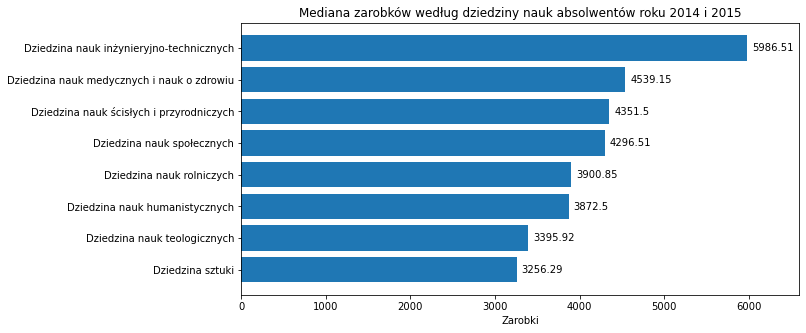

In [153]:
#srednie zarobki w dziedzinach nauk
zardziedatamed = data1.groupby("P_DZIEDZINA").agg({"P_ME_ZAR_P5":'mean'}).sort_values(by="P_ME_ZAR_P5",ascending=True)
zardziedatamed = zardziedatamed.reset_index()

fieldPopularityPlot(zardziedatamed['P_DZIEDZINA'],zardziedatamed["P_ME_ZAR_P5"],
        "Mediana zarobków według dziedziny nauk absolwentów roku 2014 i 2015",
        "ZarobkiWdziedzinachMed",6600)

Najlepsze Wojewodztwa zarobki średnia

In [154]:
bestinwojsr = data1.groupby(["P_WOJ"])["P_E_ZAR_P5"].transform(max)==data1['P_E_ZAR_P5']
bestinwojsr = data1[bestinwojsr].sort_values("P_E_ZAR_P5",ascending=False).reset_index()
bestinwojsr.index+=1
bestinwojsr=bestinwojsr.iloc[:,[6,1,3,8]].rename(columns={
    "P_WOJ":"Wojewodztwo",
    "P_NAZWA_UCZELNI":'Nazwa uczelni',
    "P_NAZWA_KIERUNKU_PELNA":"Nazwa kierunku",
    "P_E_ZAR_P5":"Średnie zarobki"})
bestinwojsr.to_excel("bestinwojsr.xlsx")
bestinwojsr.head() #dla podgladu

,Wojewodztwo,Nazwa uczelni,Nazwa kierunku,Średnie zarobki
1,Małopolskie,Akademia Górniczo-Hutnicza im. Stanisława Stas...,"Informatyka, studia stacjonarne drugiego stopn...",14338.935
2,Mazowieckie,Polsko-Japońska Akademia Technik Komputerowych,"Informatyka, studia niestacjonarne drugiego st...",13197.790
3,Dolnoślaśkie,Uniwersytet Ekonomiczny we Wrocławiu,"Zarządzanie, studia niestacjonarne drugiego st...",12243.630
4,Pomorskie,Politechnika Gdańska,"Informatyka, studia stacjonarne drugiego stopn...",12109.150
5,Wielkopolskie,Politechnika Poznańska,"Informatyka, studia stacjonarne drugiego stopn...",10966.305


Najlepsze Wojewodztwa zarobki mediana

In [155]:
bestinwojmed = data1.groupby(["P_WOJ"])["P_E_ZAR_P5"].transform(max)==data1['P_E_ZAR_P5']
bestinwojmed = data1[bestinwojmed].sort_values("P_ME_ZAR_P5",ascending=False).reset_index()
bestinwojmed.index+=1
bestinwojmed=bestinwojmed.iloc[:,[6,1,3,9]].rename(columns={
    "P_WOJ":"Wojewodztwo",
    "P_NAZWA_UCZELNI":'Nazwa uczelni',
    "P_NAZWA_KIERUNKU_PELNA":"Nazwa kierunku",
    "P_ME_ZAR_P5":"Mediana zarobków"})
bestinwojmed.to_excel("bestinwojmed.xlsx")
bestinwojmed.head() #dla podgladu

,Wojewodztwo,Nazwa uczelni,Nazwa kierunku,Mediana zarobków
1,Małopolskie,Akademia Górniczo-Hutnicza im. Stanisława Stas...,"Informatyka, studia stacjonarne drugiego stopn...",15177.510
2,Mazowieckie,Polsko-Japońska Akademia Technik Komputerowych,"Informatyka, studia niestacjonarne drugiego st...",13586.030
3,Pomorskie,Politechnika Gdańska,"Informatyka, studia stacjonarne drugiego stopn...",12618.515
4,Warmińsko-mazurskie,Uniwersytet Warmińsko-Mazurski w Olsztynie,"Kierunek lekarski, stacjonarne jednolite studi...",10247.810
5,Wielkopolskie,Politechnika Poznańska,"Informatyka, studia stacjonarne drugiego stopn...",10137.650


Najlepsze Polska zarobki średnia

In [156]:
# 10 najlepszych kierunkow ze wzgleud na srednie zarobki
best10sr = data1.sort_values(by="P_E_ZAR_P5",ascending=False).iloc[:10].reset_index()
best10sr.index+=1
best10sr = best10sr.iloc[:,[1,3,8]].rename(columns={
    "P_NAZWA_UCZELNI":'Nazwa uczelni',
    "P_NAZWA_KIERUNKU_PELNA":"Nazwa kierunku",
    "P_E_ZAR_P5":"Średnie zarobki"})
best10sr.to_excel("best10sr.xlsx")
best10sr.head() #dla podgladu

,Nazwa uczelni,Nazwa kierunku,Średnie zarobki
1,Akademia Górniczo-Hutnicza im. Stanisława Stas...,"Informatyka, studia stacjonarne drugiego stopn...",14338.935
2,Akademia Górniczo-Hutnicza im. Stanisława Stas...,"Informatyka stosowana, studia stacjonarne drug...",13557.190
3,Uniwersytet Jagielloński w Krakowie,"Informatyka, studia stacjonarne drugiego stopn...",13289.935
4,Polsko-Japońska Akademia Technik Komputerowych,"Informatyka, studia niestacjonarne drugiego st...",13197.790
5,Politechnika Warszawska,"Informatyka, studia stacjonarne drugiego stopn...",13053.660


Najlepsze Polska zarobki mediana

In [157]:
# 10 najlepszych kierunkow ze wzgleud na mediane zarobków
best10med = data1.sort_values(by="P_ME_ZAR_P5",ascending=False).iloc[:10].reset_index()
best10med.index+=1
best10med = best10med.iloc[:,[1,3,9]].rename(columns={
    "P_NAZWA_UCZELNI":'Nazwa uczelni',
    "P_NAZWA_KIERUNKU_PELNA":"Nazwa kierunku",
    "P_ME_ZAR_P5":"Mediana zarobków"
    })
best10med.to_excel("best10med.xlsx")
best10med.head() #dla podgladu

,Nazwa uczelni,Nazwa kierunku,Mediana zarobków
1,Akademia Górniczo-Hutnicza im. Stanisława Stas...,"Informatyka, studia stacjonarne drugiego stopn...",15177.510
2,Polsko-Japońska Akademia Technik Komputerowych,"Informatyka, studia niestacjonarne drugiego st...",14264.420
3,Politechnika Warszawska,"Informatyka, studia stacjonarne drugiego stopn...",14038.355
4,Polsko-Japońska Akademia Technik Komputerowych,"Informatyka, studia niestacjonarne drugiego st...",13586.030
5,Politechnika Warszawska,"Informatyka, studia stacjonarne drugiego stopn...",13216.630
